In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9e4e51b45b41f1733c8b8000c14988d691e7885fcd7fd300f4e20f5590dfc4c1
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
INPUT_PATH = "/content/drive/MyDrive/butterfly/dataset"
OUTPUT_PATH = "/content/drive/MyDrive/butterfly"

In [4]:
import os
import cv2
import glob
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from sklearn.metrics import accuracy_score
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

device='cuda'

In [5]:
all_paths = sorted(glob.glob(f"{INPUT_PATH}/*/*"))
image_id = list(map(lambda x: x.split('/')[-1], all_paths))
classes = list(map(lambda x: x.split('/')[-2], all_paths))
df = pd.DataFrame({"id" : image_id,"classs": classes, "path" : all_paths})
df = df.drop_duplicates(subset = 'id').reset_index(drop=True)

In [6]:
df

,id,classs,path
0,cropped_th_01CuretisDentata_RohanLovalekar_ab4...,Acute Sunbeam,/content/drive/MyDrive/butterfly/dataset/Acute...
1,cropped_th_02CuretisDentata_RohanLovalekar_ab4...,Acute Sunbeam,/content/drive/MyDrive/butterfly/dataset/Acute...
2,cropped_th_03CuretisDentata_SatyendraTiwari_ag...,Acute Sunbeam,/content/drive/MyDrive/butterfly/dataset/Acute...
3,cropped_th_04CuretisDentata_PareshChuri_aj567.jpg,Acute Sunbeam,/content/drive/MyDrive/butterfly/dataset/Acute...
4,cropped_th_1069_41273-41-5cec23f60fb61-1.jpg,Acute Sunbeam,/content/drive/MyDrive/butterfly/dataset/Acute...
...,...,...,...
13905,cropped_th_tbe544.jpg,Zebra Blue,/content/drive/MyDrive/butterfly/dataset/Zebra...
13906,cropped_th_tbe545.jpg,Zebra Blue,/content/drive/MyDrive/butterfly/dataset/Zebra...
13907,cropped_th_tbe869.jpg,Zebra Blue,/content/drive/MyDrive/butterfly/dataset/Zebra...
13908,cropped_th_tbe870.jpg,Zebra Blue,/content/drive/MyDrive/butterfly/dataset/Zebra...


In [7]:
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, shuffle=True, stratify=df.classs)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

In [8]:
classes = np.unique(df.classs).tolist()

In [9]:
class ButterFlyDataset(Dataset):
  def __init__(self, df, classes ,transform=None):
    super().__init__()
    self.df = df
    self.classes = classes
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    path = self.df.iloc[idx].path
    name = path.split('/')[-2]
    label = self.classes.index(name)
    image = Image.open(path).convert("RGB")

    if self.transform:
      image = self.transform(image)
    
    return {
        "image" : image,
        "label" : label
    }

In [10]:
mytransform1 = transforms.Compose(
    [
     transforms.Resize((256,256)), 
     transforms.ToTensor(),
     transforms.RandomCrop((224, 224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-60, 60)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


mytransform2 = transforms.Compose(
    [
     transforms.Resize((224,224)), 
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [11]:
ds = ButterFlyDataset(df, classes, transform=mytransform1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


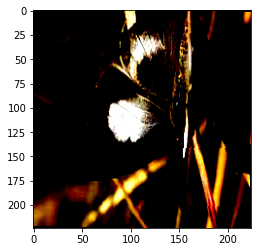

In [12]:
plt.imshow(ds[2]['image'].permute(1,2,0))

In [19]:
# Training
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=199)
model.to(device)
EPOCHS = 10

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [13]:
## Retraining
model = EfficientNet.from_name('efficientnet-b0', num_classes=199)
model.load_state_dict(torch.load(f"{OUTPUT_PATH}/model.bin"))
model.to(device)
EPOCHS = 10

In [20]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
schedular = None

In [21]:
def train(model, dataloader, optimizer, schedular, device):
  print("Training Started")
  model.train()
  total_loss = 0.0
  final_targets = []
  final_outputs = []

  for data in tqdm(dataloader):
    image = data['image'].to(device)
    label = data['label'].to(device)

    outs = model(image)

    loss = criterion(outs, label)
    total_loss += loss.item()

    model.zero_grad()
    loss.backward()
    optimizer.step()

    final_targets.extend(label.detach().cpu().numpy().tolist())
    final_outputs.extend(torch.argmax(outs, axis=-1).detach().cpu().numpy().tolist())

  score = accuracy_score(final_outputs, final_targets)
  print(f"Loss : {total_loss/len(dataloader)} and Accuracy Score : {score}")

  if schedular is not None:
    schedular.step()

In [22]:
def eval(model, dataloader, device):
  print("Evaluation Started")
  model.eval()
  total_loss = 0.0
  final_targets = []
  final_outputs = []

  for data in tqdm(dataloader):
    image = data['image'].to(device)
    label = data['label'].to(device)

    with torch.no_grad():
      outs = model(image)
      loss = criterion(outs, label)
      total_loss += loss.item()

    final_targets.extend(label.detach().cpu().numpy().tolist())
    final_outputs.extend(torch.argmax(outs, axis=-1).detach().cpu().numpy().tolist())

  score = accuracy_score(final_outputs, final_targets)
  print(f"Loss : {total_loss/len(dataloader)} and Accuracy Score : {score}")
  return score

In [23]:
train_dataset = ButterFlyDataset(train_df, classes, transform=mytransform1)
val_dataset = ButterFlyDataset(val_df, classes, transform=mytransform2)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [24]:
best_score = 0
for epoch in range(EPOCHS):
  print(f"Epoch : {epoch}")
  train(model, train_loader, optimizer, schedular, device)
  score = eval(model, val_loader, device)
  if score > best_score:
    print("Saving Model....")
    torch.save(model.state_dict(), f"{OUTPUT_PATH}/model.bin")
    best_score = score

Epoch : 0
Training Started



Loss : 2.2825574496740937 and Accuracy Score : 0.5078237334009981
Evaluation Started



Loss : 0.9919592954895713 and Accuracy Score : 0.6962146621945376
Saving Model....
Epoch : 1
Training Started



Loss : 0.5741788712880944 and Accuracy Score : 0.8298232259155882
Evaluation Started



Loss : 1.0376403945865054 and Accuracy Score : 0.6957355055103018
Epoch : 2
Training Started



Loss : 0.37758733604543954 and Accuracy Score : 0.8774422735346359
Evaluation Started



Loss : 0.6389035627697454 and Accuracy Score : 0.8011499760421658
Saving Model....
Epoch : 3
Training Started



Loss : 0.2536942869104365 and Accuracy Score : 0.920832276072063
Evaluation Started



Loss : 0.5180835326512655 and Accuracy Score : 0.8413991375179684
Saving Model....
Epoch : 4
Training Started



Loss : 0.19609644436227378 and Accuracy Score : 0.934618963038146
Evaluation Started



Loss : 0.49035413472941425 and Accuracy Score : 0.851461427886919
Saving Model....
Epoch : 5
Training Started



Loss : 0.17932211415421578 and Accuracy Score : 0.9429924722997547
Evaluation Started



Loss : 0.46533333758513135 and Accuracy Score : 0.8653569717297557
Saving Model....
Epoch : 6
Training Started



Loss : 0.1475213724839431 and Accuracy Score : 0.9525501141842172
Evaluation Started



Loss : 0.426974255027193 and Accuracy Score : 0.870148538572113
Saving Model....
Epoch : 7
Training Started



Loss : 0.12993058041539243 and Accuracy Score : 0.959908652626237
Evaluation Started



Loss : 0.3559034349340381 and Accuracy Score : 0.883564925730714
Saving Model....
Epoch : 8
Training Started



Loss : 0.11919638037841807 and Accuracy Score : 0.9616848515605176
Evaluation Started



Loss : 0.3794529548648632 and Accuracy Score : 0.8917105893627216
Saving Model....
Epoch : 9
Training Started



Loss : 0.10872217023404696 and Accuracy Score : 0.9649835067241816
Evaluation Started



Loss : 0.5100187925678311 and Accuracy Score : 0.8596070915189267
